 # Table of Contents
<div class="toc" style="margin-top: 1em;"><ul class="toc-item" id="toc-level0"><li><span><a href="http://localhost:8888/notebooks/Forecast.ipynb#Table-Creation" data-toc-modified-id="Table-Creation-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Table Creation</a></span></li><li><span><a href="http://localhost:8888/notebooks/Forecast.ipynb#Generate-samples" data-toc-modified-id="Generate-samples-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Generate samples</a></span><ul class="toc-item"><li><span><a href="http://localhost:8888/notebooks/Forecast.ipynb#Views" data-toc-modified-id="Views-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Views</a></span></li></ul></li></ul></div>

# Forecast

In [1]:
from datetime import datetime, timedelta
from eralchemy import render_er
from IPython.display import display
from matplotlib import pyplot as plt
from PIL import Image
from sqlalchemy import create_engine

import numpy as np
import pandas as pd
import psycopg2
import random
import sqlalchemy as sqla
import sqlite3
import string

## Table Creation

In [2]:
def get_passwd_from_ini(filepath: str):
    with open(filepath) as f:
        text = f.read()
        i = text.index('PSQL_PASSWORD')
        f = text[i:].index('\n')
        passwd = text[i:i+f].split('=')
        return passwd[1].strip()

In [3]:
# set connection

db = 'dengue'
user = 'dengueadmin'
host = 'localhost'
passwd = get_passwd_from_ini('../AlertaDengue/AlertaDengue/settings.ini')
dsn = "postgresql://{}:{}@{}/{}".format(
    user, passwd, host, db
)

engine = create_engine(dsn)

In [4]:
def create_tables():
    with engine.connect() as conn:
        conn.execute('DROP TABLE IF EXISTS "Municipio".forecast_model CASCADE;')
        conn.execute('DROP TABLE IF EXISTS "Municipio".forecast_city CASCADE;')
        conn.execute('DROP TABLE IF EXISTS "Municipio".forecast CASCADE;')

        # Create forecast_model table
        conn.execute('''
        CREATE TABLE IF NOT EXISTS "Municipio".forecast_model (
            id SERIAL PRIMARY KEY,
            name VARCHAR(128) NOT NULL,
            weeks SMALLINT NOT NULL,
            commit_id CHAR(7) NOT NULL,
            active BOOL NOT NULL
        )''')

        # Create forecast table
        conn.execute('''
        CREATE TABLE IF NOT EXISTS "Municipio".forecast (
            epiweek INT NOT NULL,
            geocode INT NOT NULL,
            cid10 character varying(5) NOT NULL,
            forecast_model_id INT,
            published_date date NOT NULL,
            init_date_epiweek date NOT NULL,
            cases INT NOT NULL,
            
            PRIMARY KEY (
              epiweek, geocode, cid10, forecast_model_id, published_date
            ),
            FOREIGN KEY(forecast_model_id) 
              REFERENCES "Municipio".forecast_model(id),
            FOREIGN KEY(geocode) 
              REFERENCES "Dengue_global"."Municipio"(geocodigo),
            FOREIGN KEY(cid10) REFERENCES "Dengue_global"."CID10"(codigo)
        )''')

        # Create forecast_city table
        # USING SERIAL BEACAUSE SOME DJANGO ISSUES
        # https://code.djangoproject.com/wiki/MultipleColumnPrimaryKeys
        conn.execute('''
        CREATE TABLE IF NOT EXISTS "Municipio".forecast_city (
            id SERIAL PRIMARY KEY,
            geocode INT NOT NULL,
            forecast_model_id INT,
            active BOOL NOT NULL,
            UNIQUE (geocode, forecast_model_id),
            FOREIGN KEY(forecast_model_id) REFERENCES "Municipio".forecast_model(id),
            FOREIGN KEY(geocode) REFERENCES "Dengue_global"."Municipio"(geocodigo)
        )''')

create_tables()

In [5]:
# render_er(dsn, '/tmp/img.png', schema='Municipio')
# Image.open('/tmp/img.png')

## Generate samples

In [6]:
# SETTINGS

# CIDs to be used to generate samples
CID10 = {
    'dengue': 'A90',
    'zika': 'A928',
    'chikungunya': 'A920'
}

rio_id = 3304557
curitiba_id = 4106902
# Cities to be used to generate samples
cities = {
    'curitiba': curitiba_id,
    'rio': rio_id
}

# Total of forecast model to generate
TOTAL_FORECAST_MODELS = 5
TOTAL_WEEKS = 5

In [7]:
def generate_sample_forecast(output):
    """
    Generate sample to test forecast table
    
    -------
    FIELDS:
    -------
    epiweek INT NOT NULL,
    geocode INT NOT NULL,
    cid10 character varying(5) NOT NULL,
    forecast_model_id INT,
    published_date date NOT NULL,
    init_date_epiweek date NOT NULL,
    cases INT NOT NULL,
    
    """
    sql = '''
    INSERT INTO "Municipio".forecast (
     epiweek, geocode, cid10, forecast_model_id, 
     published_date, init_date_epiweek, cases
    ) VALUES (%s,%s,'%s',%s,'%s','%s',%s);
    '''.replace('\n', '').strip()
    
    for city_name, geocode in cities.items():
        for cid_name, cid_id in CID10.items():
            for forecast_model_id in range(1, TOTAL_FORECAST_MODELS+1):
                # wr = week of reference
                for wr in range(10):
                    # date of reference
                    dr = (
                        datetime.strptime('2017-01-01', '%Y-%m-%d') + 
                        timedelta(days=7*wr)
                    )

                    for w in range(1, TOTAL_WEEKS+1):
                        # di = initial date
                        di = dr + timedelta(days=7*w)
                        # dp = published date
                        dp = dr

                        init_date = di.strftime('%Y-%m-%d')
                        published_date = dr.strftime('%Y-%m-%d')
                        
                        epiweek = '2017%s' % str(w+wr+1).rjust(2, '0')
                        cases = int(np.random.randint(0, 6000, 1))
                        

                        if forecast_model_id >= 6:
                            print(forecast_model_id)
                        text = sql % (
                            epiweek, geocode, cid_id, forecast_model_id,
                            published_date, init_date, cases
                        )

                        print(text, file=output)


In [8]:
def generate_sample_forecast_model(output):
    """
    Generate sample to test forecast_model table
    
    -------
    FIELDS:
    -------
    id SERIAL PRIMARY KEY,
    name VARCHAR(128) NOT NULL,
    weeks SMALLINT NOT NULL,
    commit_id CHAR(7) NOT NULL,
    active BOOL NOT NULL
    
    """
    sql = '''
    INSERT INTO "Municipio".forecast_model (
     name, weeks, commit_id, active
    ) VALUES (\'%s\',%s,\'%s\',%s);
    '''.replace('\n', '').strip()
    
    for i, active in enumerate([True]*(TOTAL_FORECAST_MODELS-1) + [False]):
        name = 'Model%s' % (i+1)
        total_weeks = TOTAL_WEEKS
        commit_id = ''.join(
            random.choices(string.ascii_uppercase + string.digits, k=7)
        )
        text = sql % (
            name, total_weeks, commit_id, active
        )

        print(text, file=output)

In [9]:
def generate_sample_forecast_city(output):
    """
    Generate sample to test forecast_city table
    -------
    FIELDS:
    -------
    geocode INT NOT NULL,
    forecast_model_id INT,
    active BOOL NOT NULL,
    
    """
    sql = '''
    INSERT INTO "Municipio".forecast_city (
     geocode, forecast_model_id, active
    ) VALUES (%s,%s,%s);
    '''.replace('\n', '').strip()
    
    for geocode in cities.values():
        for forecast_model_id in range(1, TOTAL_FORECAST_MODELS+1):
            text = sql % (
                geocode, forecast_model_id, True
            )

            print(text, file=output)
            

In [10]:
create_tables()

with open('/tmp/insert.sql', 'w') as f:
    generate_sample_forecast_model(f)
    
with open('/tmp/insert.sql', 'a') as f:
    generate_sample_forecast_city(f)

with open('/tmp/insert.sql', 'a') as f:
    generate_sample_forecast(f)
    
with open('/tmp/insert.sql', 'r') as f:
    with engine.connect() as conn:
        conn.execute(f.read())

### Views

In [11]:
%matplotlib notebook

In [12]:
# sql settings
epiweek = 201702
cid10 = CID10['dengue']
geocode = rio_id

sql = '''
SELECT DISTINCT ON (forecast.forecast_model_id)
  forecast.forecast_model_id, 
  forecast_model.name AS forecast_model_name,
  forecast.published_date
FROM 
  "Municipio".forecast 
  INNER JOIN "Municipio".forecast_model
    ON (
      "Municipio".forecast.forecast_model_id =  
      "Municipio".forecast_model.id
    )
WHERE
  cid10 = '%s'
  AND geocode = %s
  AND epiweek = %s
ORDER BY forecast_model_id, published_date DESC
''' % (cid10, geocode, epiweek)

df_forecast_model = pd.read_sql(sql, con=engine)

df_forecast_model

,forecast_model_id,forecast_model_name,published_date
0,1,Model1,2017-01-01
1,2,Model2,2017-01-01
2,3,Model3,2017-01-01
3,4,Model4,2017-01-01
4,5,Model5,2017-01-01


<class 'pandas.core.frame.DataFrame'>
Index: 403 entries, 2010-01-03 to 2017-09-17
Data columns (total 12 columns):
casos_est_min            403 non-null float64
casos_est                403 non-null float64
casos_est_max            403 non-null float64
casos                    403 non-null int64
nivel                    403 non-null int64
SE                       403 non-null int64
p_rt1                    403 non-null float64
forecast_model1_cases    5 non-null float64
forecast_model2_cases    5 non-null float64
forecast_model3_cases    5 non-null float64
forecast_model4_cases    5 non-null float64
forecast_model5_cases    5 non-null float64
dtypes: float64(9), int64(3)
memory usage: 40.9+ KB


None

<IPython.core.display.Javascript object>


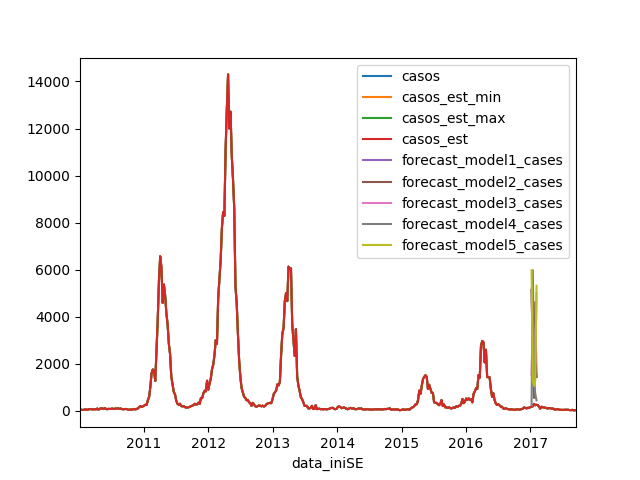

In [13]:
sql = """
SELECT 
    (CASE 
     WHEN tb_cases."data_iniSE" IS NOT NULL 
       THEN tb_cases."data_iniSE" 
     %(forecast_date_ini_epiweek)s
     ELSE NULL
     END
    ) AS "data_iniSE",
    tb_cases.casos_est_min,
    tb_cases.casos_est,
    tb_cases.casos_est_max,
    tb_cases.casos,
    tb_cases.nivel,
    (CASE 
     WHEN tb_cases."SE" IS NOT NULL THEN tb_cases."SE" 
     %(forecast_epiweek)s
     ELSE NULL
     END
    ) AS "SE",
    tb_cases.p_rt1
    %(forecast_models_cases)s
FROM
    (SELECT 
       data AS "data_iniSE",
       SUM(casos_estmin) AS casos_est_min,
       SUM(casos_est) as casos_est,
       SUM(casos_estmax) AS casos_est_max,
       SUM(casos) AS casos,
       MAX(nivel) AS nivel,
       se AS "SE",
       SUM(prt1) AS p_rt1
     FROM "Municipio".alerta_mrj
     GROUP BY "data_iniSE", "SE"
    ) AS tb_cases %(forecast_models_joins)s
ORDER BY "data_iniSE" ASC
"""

sql_forecast_by_model = '''
FULL OUTER JOIN (
  SELECT 
    epiweek, 
    init_date_epiweek,
    cases AS forecast_%(model_name)s_cases
  FROM "Municipio".forecast
  WHERE
    cid10='%(cid10)s'
    AND geocode=%(geocode)s
    AND published_date='%(published_date)s'
    AND forecast_model_id=%(model_id)s
) AS forecast%(model_id)s ON (
  tb_cases."SE" = forecast%(model_id)s.epiweek 
)
'''
forecast_date_ini_epiweek = ''
forecast_models_cases = ''
forecast_models_joins = ''
forecast_epiweek = ''
forecast_config = {
    'geocode': geocode,
    'cid10': cid10,
    'published_date': None,
    'model_name': None,
    'model_id': None
}

for i, row in df_forecast_model.iterrows():
    forecast_config.update({
        'published_date': row.published_date,
        'model_name': row.forecast_model_name,
        'model_id': row.forecast_model_id
    })
    # forecast models join sql
    forecast_models_joins += sql_forecast_by_model % (forecast_config)
    
    # forecast date ini selection
    forecast_date_ini_epiweek += '''
    WHEN forecast%(model_id)s.init_date_epiweek IS NOT NULL 
       THEN forecast%(model_id)s.init_date_epiweek
    ''' % (forecast_config)
    
    # forecast epiweek selection
    forecast_epiweek += '''
    WHEN forecast%(model_id)s.epiweek IS NOT NULL 
       THEN forecast%(model_id)s.epiweek
    ''' % (forecast_config)
    
    # forecast models cases selection
    forecast_models_cases += (
        ',forecast_%(model_name)s_cases' % (forecast_config)
    )
    
if forecast_models_cases == '':
    forecast_models_cases = '1'
    
sql = sql % {
    'forecast_models_joins': forecast_models_joins,
    'forecast_models_cases': forecast_models_cases,
    'forecast_date_ini_epiweek': forecast_date_ini_epiweek,
    'forecast_epiweek': forecast_epiweek
}

# print(sql)

df = pd.read_sql(sql, con=engine, index_col='data_iniSE')

# print(df.shape)
display(df.info())

k = ['casos', 'casos_est_min', 'casos_est_max', 'casos_est']
k += [c for c in df.keys() if c.startswith('forecast')]

df[k].plot()

plt.show()